# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [55]:
import io
import os
import numpy as np
import scipy
import urllib.request

In [49]:
PATH_TO_DATA = "/Users/wangkewei/Desktop/deeplearning/mini2/nlp_project/data/"
PATH_TO_DATA_SST = PATH_TO_DATA + "SST/"
PATH_TO_DATA_RES = PATH_TO_DATA + "RES/"

# 1) Monolingual (English) word embeddings 

In [56]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        if fname[0:4] == 'http':
            self.load_wordvec_url(fname, nmax)
        else:
            self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))
        
    def load_wordvec_url(self, flink, nmax):
        self.word2vec = {}
        with urllib.request.urlopen(flink) as f:
            next(f)
            for i, line in enumerate(f):
                line = line.decode('utf-8')
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i % 1000 == 0:
                    print(i, end=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        all_list = []
        for key in self.word2vec:
            if key != w:
                all_list.append((self.score(key, w), key))
        topk = sorted(all_list, key=lambda x: x[0], reverse=True)[0:K]
        # K most similar words: self.score  -  np.argsort
        return topk

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if type(w1) == str:
            vw1 = self.word2vec[w1]
        else:
            vw1 = w1
        if type(w2) == str:
            vw2 = self.word2vec[w2]
        else:
            vw2 = w2
        return (np.dot(vw1, vw2) / (np.linalg.norm(vw1) * np.linalg.norm(vw2)))


In [51]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=70000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 70000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
[(0.8353184714264993, 'cats'), (0.8034410478493814, 'kitty'), (0.8024762062392743, 'kitten'), (0.768065407691186, 'feline'), (0.7237089223394708, 'kitties')]
[(0.855207916336258, 'dogs'), (0.784569427961543, 'puppy'), (0.7511571638004245, 'Dog'), (0.744241335717672, 'doggie'), (0.7421250622701407, 'canine')]
[(0.855207916336258, 'dog'), (0.7704396457434113, 'Dogs'), (0.7699192773615036, 'doggies'), (0.7527040042648147, 'canines'), (0.7135063992407494, 'puppies')]
[(0.7775108541288558, 'france'), (0.6845140397494098, 'Paris'), (0.6728545431461277, 'london'), (0.6424447628126261, 'berlin'), (0.6409621495653872, 'tokyo')]
[(0.7597591231074469, 'europe'), (0.7445826305760618, 'german'), (0.7420295235998394, 'berlin'), (0.700162288191849, 'sweden'), (0.6968344551813622, 'france')]


In [52]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
                
        sentemb = []
        dictionary = self.w2v.word2vec
        for sent in sentences:
            if idf is False:
                sentemb.append(np.mean([dictionary[w] for w in sent.strip().split() if w in dictionary], axis=0))
            else:
                sentemb.append(np.mean([dictionary[w]*idf[w] for w in sent.strip().split() if w in dictionary], axis=0))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        all_list = []
        for sent in sentences:
            if sent != s:
                all_list.append((self.score(sent, s, idf), sent))
        topk = sorted(all_list, key=lambda x: x[0], reverse=True)[0:K]
        return topk

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        vec1 = self.encode([s1], idf).flatten()
        vec2 = self.encode([s2], idf).flatten()
        return (np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in sent.strip().split():
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        
        return idf


In [53]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=70000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(PATH_TO_DATA+"sentences.txt") as f:
    for line in f:
        sentences.append(line)

# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
# BoV-mean
li = s2v.most_similar('' if not sentences else sentences[10], sentences)
print("\nBoV-mean:")
for x in li:
    print(x[0], '\t'+x[1], end='')
print("score:", s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

# BoV-idf
li = s2v.most_similar('' if not sentences else sentences[10], sentences, idf)
print("\nBoV-idf:")
for x in li:
    print(x[0], '\t'+x[1], end='')
print("score:", s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 70000 pretrained word vectors

BoV-mean:
0.9170453357707757 	an african american man smiling . 
0.8498556003875812 	a little african american boy and girl looking up . 
0.82209722421572 	an african american in sunglasses and a white tee-shirt smiles . 
0.8217139139540895 	an afican american woman standing behind two small african american children . 
0.8207047384633509 	an african american man is sitting . 
score: 0.5726258859719607

BoV-idf:
0.9222156774278677 	an african american man smiling . 
0.8717942965938766 	an african american man is sitting . 
0.8653518571064774 	a little african american boy and girl looking up . 
0.8552291860045897 	an afican american woman standing behind two small african american children . 
0.8467228995937571 	a girl in black hat holding an african american baby . 
score: 0.47509279801053633


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [57]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

link_en = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec"
link_fr = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec"

nmax = 5000  
w2v_en = Word2vec(link_en, nmax)
w2v_fr = Word2vec(link_fr, nmax)


0 1000 2000 3000 4000 Loaded 5000 pretrained word vectors
0 1000 2000 3000 4000 Loaded 5000 pretrained word vectors


In [2]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
# X french
# Y english
x = []
y = []
for w in w2v_en.word2vec:
    if w in w2v_fr.word2vec:
        x.append(list(w2v_fr.word2vec[w]))
        y.append(list(w2v_en.word2vec[w]))

X = np.array(x).transpose() # X.shape = (300, nb)
Y = np.array(y).transpose() # Y.shape = (300, nb)

In [3]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, sigma, Vt = np.linalg.svd(np.dot(Y, X.transpose()))
W = np.dot(U, Vt)
W = np.mat(W) # W.shape = (300, 300)

In [4]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
print("English -> French:")
# If you want to test more words, please increase the nmax value !!!
for w in ['cat', 'dog']:
    print("\n"+w)
    vw_y = w2v_en.word2vec[w]
    # X = np.dot(W.I, Y)
    vw_x = list(np.array(np.dot(W.I, vw_y).transpose()).flatten())
    li = w2v_fr.most_similar(vw_x)
    for x in li:
        print(x[1]+'\t', x[0])
        
print("\nFrench -> English:")
# If you want to test more words, please increase the nmax value !!!
for w in ['chat', 'chien']:
    print("\n"+w)
    vw_x = w2v_fr.word2vec[w]
    # Y = np.dot(W, X)
    vw_y = list(np.array(np.dot(W, vw_x).transpose()).flatten())
    li = w2v_en.most_similar(vw_y)
    for x in li:
        print(x[1]+'\t', x[0])

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [58]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
x_train = []
y_train = []
with open(PATH_TO_DATA_SST+"stsa.fine.train") as f:
    for line in f:
        y, x = line.strip().split(' ', 1)
        x_train.append(x)
        y_train.append(int(y))
l_train = len(x_train)
        
x_dev = []
y_dev = []
with open(PATH_TO_DATA_SST+"stsa.fine.dev") as f:
    for line in f:
        y, x = line.strip().split(' ', 1)
        x_dev.append(x)
        y_dev.append(int(y))
l_dev = len(x_dev)

x_test = []
with open(PATH_TO_DATA_SST+"stsa.fine.test.X") as f:
    for line in f:
        x_test.append(line)
l_test = len(x_test)

In [59]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=70000)
s2v = BoV(w2v)

# Build idf scores for each word
idf = {} if False else s2v.build_idf(x_train+x_dev+x_test)

x_train_bov = s2v.encode(x_train, idf)
x_dev_bov = s2v.encode(x_dev, idf)
x_test_bov = s2v.encode(x_test, idf)

#x_train_bov = s2v.encode(x_train)
#x_dev_bov = s2v.encode(x_dev)
#x_test_bov = s2v.encode(x_test)

Loaded 70000 pretrained word vectors


In [60]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=150, random_state=9, multi_class='multinomial')
lr.fit(x_train_bov, y_train)
print("score : %f " % (lr.score(x_dev_bov, y_dev)))

score : 0.421435 


In [64]:
y_test_bov=lr.predict(x_test_bov)

In [68]:
data=open(PATH_TO_DATA_RES+"logreg_bov_y_test_sst.txt",'w+') 
print(y_test_bov,file=data)
data.close()

In [69]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_pred = lr.predict(x_test_bov)
with open(PATH_TO_DATA_RES+"logreg_bov_y_test_sst.txt", "w") as f:
    for i in y_pred:
        f.write(str(i)+'\n')

In [9]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [70]:
import keras

Using TensorFlow backend.


In [71]:
# 1 - Load train/dev/test sets of SST

# TYPE CODE HERE
x_train = []
y_train = []
with open(PATH_TO_DATA_SST+"stsa.fine.train") as f:
    for line in f:
        y, x = line.strip().split(' ', 1)
        x_train.append(x)
        y_train.append(y)
l_train = len(x_train)
        
x_dev = []
y_dev = []
with open(PATH_TO_DATA_SST+"stsa.fine.dev") as f:
    for line in f:
        y, x = line.strip().split(' ', 1)
        x_dev.append(x)
        y_dev.append(y)
l_dev = len(x_dev)

x_test = []
with open(PATH_TO_DATA_SST+"stsa.fine.test.X") as f:
    for line in f:
        x_test.append(line)
l_test = len(x_test)

In [72]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
N = 50000
max_len = 60

x_train_oh = [text.one_hot(i, n=N, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=True, split=' ') for i in x_train]
x_dev_oh = [text.one_hot(i, n=N, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=True, split=' ') for i in x_dev]
x_test_oh = [text.one_hot(i, n=N, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=True, split=' ') for i in x_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [73]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
x_train_oh = keras.preprocessing.sequence.pad_sequences(x_train_oh, maxlen=max_len, dtype='int32', padding='pre', truncating='pre', value=0.)
x_dev_oh = keras.preprocessing.sequence.pad_sequences(x_dev_oh, maxlen=max_len, dtype='int32', padding='pre', truncating='pre', value=0.)
x_test_oh = keras.preprocessing.sequence.pad_sequences(x_test_oh, maxlen=max_len, dtype='int32', padding='pre', truncating='pre', value=0.)

from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_dev_cat = to_categorical(y_dev)

## 4.2 - Design and train your model

In [79]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = N  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=max_len))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

In [80]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 32)            1600000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 6

history = model.fit(x_train_oh, y_train_cat, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_oh, y_dev_cat))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 45s 5ms/step - loss: 1.5724 - acc: 0.2694 - val_loss: 1.5658 - val_acc: 0.2761
Epoch 2/6
8544/8544 [==============================] - 44s 5ms/step - loss: 1.4884 - acc: 0.3639 - val_loss: 1.4508 - val_acc: 0.3669
Epoch 3/6
8544/8544 [==============================] - 42s 5ms/step - loss: 1.1762 - acc: 0.5150 - val_loss: 1.4119 - val_acc: 0.3924
Epoch 4/6
8544/8544 [==============================] - 42s 5ms/step - loss: 0.8551 - acc: 0.6716 - val_loss: 1.5481 - val_acc: 0.3642
Epoch 5/6
8544/8544 [==============================] - 47s 5ms/step - loss: 0.6194 - acc: 0.7827 - val_loss: 1.7034 - val_acc: 0.3615
Epoch 6/6
8544/8544 [==============================] - 47s 5ms/step - loss: 0.4347 - acc: 0.8525 - val_loss: 1.9451 - val_acc: 0.3660


In [90]:
history_dict = history.history
loss_values = np.array(history_dict['loss'])
val_loss_values = np.array(history_dict['val_loss'])
epochs = np.array(range(1, len(loss_values)+1))
train_acc = np.array(history_dict['acc'])
val_acc = np.array(history_dict['val_acc'])

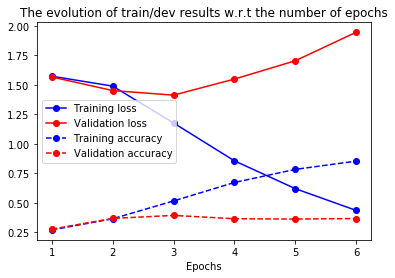

In [104]:
import matplotlib.pyplot as plt
plt.plot(epochs,loss_values,label="Training loss",c="blue",marker='o')
plt.plot(epochs,val_loss_values,label="Validation loss",c="red",marker='o')
plt.plot(epochs,train_acc,label="Training accuracy",c="blue",marker='o',ls='--')
plt.plot(epochs,val_acc,label="Validation accuracy",c="red",marker='o',ls='--')
plt.legend()
plt.xlabel('Epochs')
plt.title('The evolution of train/dev results w.r.t the number of epochs')
plt.show()

In [82]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_pred = model.predict_classes(x_test_oh)
with open(PATH_TO_DATA_RES+"logreg_lstm_y_test_sst.txt", "w") as f:
    for i in y_pred:
        f.write(str(i)+'\n')

## 4.3 -- innovate !

In [105]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

Loaded 100000 pretrained word vectors


In [106]:
from keras.preprocessing.text import Tokenizer
x_all = x_train + x_dev + x_test
tk = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x_all)
x_all_tk = tk.texts_to_sequences(x_all)

# Padding the short sentence with 0, all the x_train/dev/test have the same length
max_len = 60
x_all_tk = keras.preprocessing.sequence.pad_sequences(x_all_tk, max_len)
x_train_tk = x_all_tk[0:l_train]
x_dev_tk = x_all_tk[l_train:l_train + l_dev]
x_test_tk = x_all_tk[l_train + l_dev:]

# Creat the embedding matrix. It is a hashing table.
embedding_matrix = np.zeros((len(tk.word_index)+1, 300))
for w, i in tk.word_index.items():
    if w in w2v.word2vec:
        embedding_matrix[i] = w2v.word2vec[w]

In [107]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.models import load_model

# specify parameters of the neural network
nhid       = 128     # number of hidden units in the LSTM
n_classes  = 5       # number of classes

# Build the model
model_LSTM = Sequential() 
model_LSTM.add(Embedding(len(tk.word_index)+1, 300, weights=[embedding_matrix], trainable=False, input_length = max_len)) # not trainable!
model_LSTM.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(n_classes, activation='softmax'))

In [108]:
# define compilation parameter
loss_classif     =  'categorical_crossentropy'
optimizer        =  'nadam' # nadam is better than adam
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model_LSTM.compile(loss=loss_classif, optimizer=optimizer, metrics=metrics_classif)
print(model_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 300)           5352000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 5,572,293
Trainable params: 220,293
Non-trainable params: 5,352,000
_________________________________________________________________
None


In [109]:
bs = 32
n_epochs = 6
history = model_LSTM.fit(x_train_tk, y_train_cat, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_tk, y_dev_cat)) 

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 195s 23ms/step - loss: 1.3820 - acc: 0.3900 - val_loss: 1.3072 - val_acc: 0.4169
Epoch 2/6
8544/8544 [==============================] - 186s 22ms/step - loss: 1.2577 - acc: 0.4555 - val_loss: 1.2661 - val_acc: 0.4405
Epoch 3/6
8544/8544 [==============================] - 186s 22ms/step - loss: 1.1922 - acc: 0.4862 - val_loss: 1.2437 - val_acc: 0.4541
Epoch 4/6
8544/8544 [==============================] - 192s 22ms/step - loss: 1.1274 - acc: 0.5181 - val_loss: 1.2827 - val_acc: 0.4405
Epoch 5/6
8544/8544 [==============================] - 186s 22ms/step - loss: 1.0560 - acc: 0.5558 - val_loss: 1.2842 - val_acc: 0.4469
Epoch 6/6
8544/8544 [==============================] - 186s 22ms/step - loss: 0.9659 - acc: 0.6001 - val_loss: 1.3148 - val_acc: 0.4396


In [111]:
y_pred_LSTM = model_LSTM.predict_classes(x_test_tk)
with open(PATH_TO_DATA_RES+"lstm_w2v_y_test_sst.txt", "w") as f:
    for i in y_pred_LSTM:
        f.write(str(i)+'\n')